## Principal Component Analysis (PCA)

### Constructing W

In [1]:
# Once again using the Wine Dataset. Load the UCI Wine dataset from the online repository into a pandas DataFrame

import pandas as pd

df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset into features (X) and labels (y)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# Split into training and test sets (70% train, 30% test)
# stratify=y ensures class proportions remain balanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

# Standardize the features (mean = 0, variance = 1)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)  # fit on training data and transform
X_test_std = sc.transform(X_test)        # use same transformation on test data

In [3]:
# Second step, constructing the covariance matrix

# Third step, obtain the eigenvalues and eigenvectors of the covariance matrix
# eigenvalues indicate the amount of variance captured by each principal component
# eigenvectors indicate the direction of the principal components
import numpy as np

# Compute the covariance matrix of the standardized training data
# Transpose because np.cov expects features as rows, not columns
cov_mat = np.cov(X_train_std.T)

# Perform eigen decomposition of the covariance matrix
# manual computation of eigenvalues and eigenvectors are tedius, so use Numpy's built-in function
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Print eigenvalues
print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


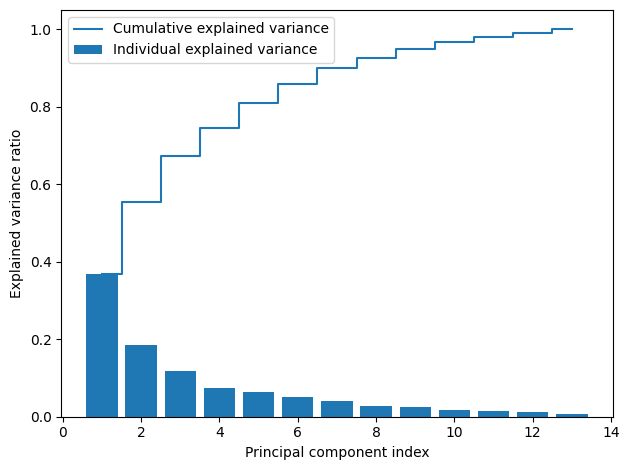

In [4]:
# The following code will create a graph that shows the indiviudual and cumulative explained variance by each principal component
# Calculate the total variance
tot = sum(eigen_vals)

# Compute the proportion of variance explained by each eigenvalue (component)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]

# Compute the cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt

# Bar chart for individual explained variance
plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')

# Step plot for cumulative explained variance
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')

# Labels and formatting
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show() # first two PC explain about 60% of the variance

#### Note: Remember that PCA is an unsupervised method, which means that information about the class labels is ignored.

In [5]:
# Next, we sort the eigenvalues and their corresponding eigenvectors in descending order
# Create a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the eigenpairs by eigenvalue (variance explained), largest first
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [6]:
# For this example, we will select the top 2 eigenvectors (principal components). In practice, you might choose more determined by a tradeoff between computational efficiency and the performance of the classifier.
# Stack the top 2 eigenvectors (column-wise) to form the projection matrix W
w = np.hstack((
    eigen_pairs[0][1][:, np.newaxis],   # eigenvector with largest eigenvalue
    eigen_pairs[1][1][:, np.newaxis]    # eigenvector with 2nd largest eigenvalue
))

print('Matrix W:\n', w) # With this we just created a 13x2-dimensional projection matrix W from the top 2 eigenvectors

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


### Using W

In [7]:
# Can now transform an eample x onto the PCA subspace, obtaining x'
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [8]:
# We can similarly transform the entire training set by caculating the dot product of the standardized training data with the projection matrix W

In [9]:
X_train_pca = X_train_std.dot(w)

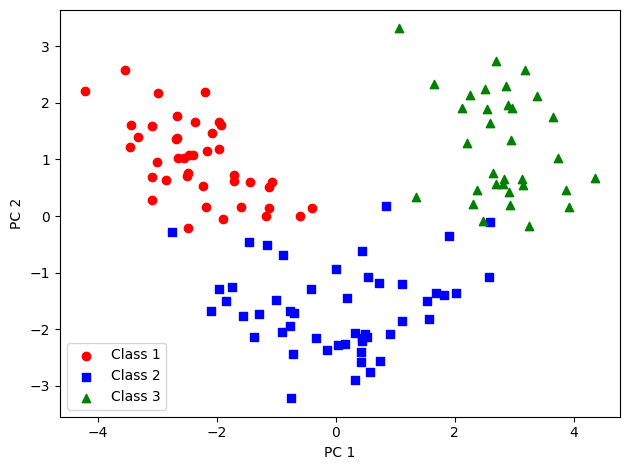

In [10]:
# Visualizing the PCA-transformed training data
colors = ['r', 'b', 'g']     # Colors for each class
markers = ['o', 's', '^']    # Different markers for each class

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],   # PC 1 coordinates for class l
                X_train_pca[y_train == l, 1],   # PC 2 coordinates for class l
                c=c,
                label=f'Class {l}',
                marker=m)

plt.xlabel('PC 1')   # Label for x-axis
plt.ylabel('PC 2')   # Label for y-axis
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Scikit-Learn PCA

In [11]:
# Bring back the plot_decision_regions function from the previous notebook to visualize the decision boundaries of a classifier in the PCA-transformed space
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


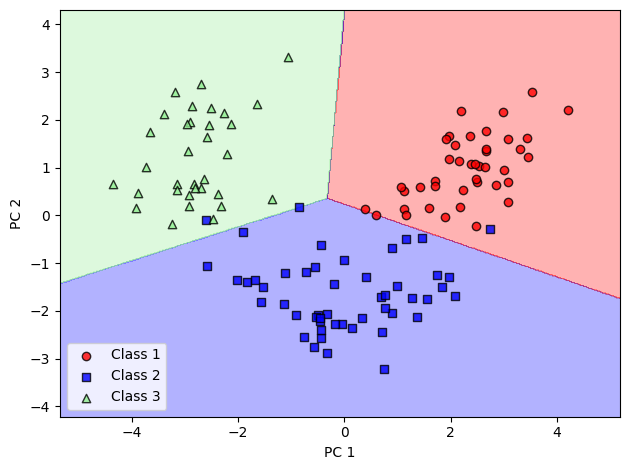

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Initialize PCA to reduce data to 2 principal components
pca = PCA(n_components=2)

# Initialize logistic regression classifier (one-vs-rest for multi-class)
lr = LogisticRegression(multi_class='ovr',
                        random_state=1,
                        solver='lbfgs')

# Apply PCA on training data (fit and transform)
X_train_pca = pca.fit_transform(X_train_std)

# Apply the same PCA transformation on test data
X_test_pca = pca.transform(X_test_std)

# Fit logistic regression on the PCA-transformed training data
lr.fit(X_train_pca, y_train)

# Plot decision boundaries for training data in the 2D PCA space
plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

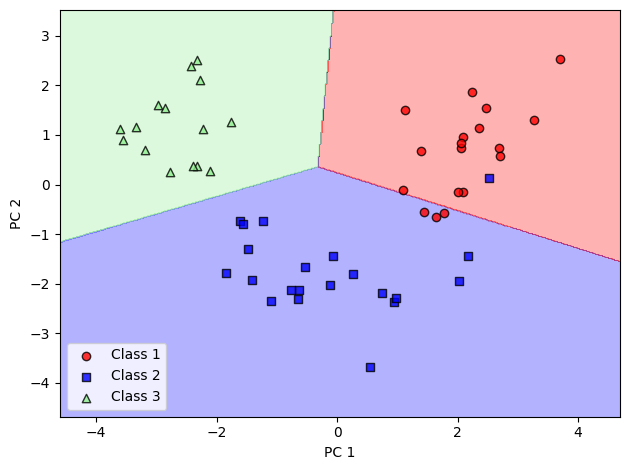

In [13]:
# Visualize decision regions on test data projected to 2D PCA space
plot_decision_regions(X_test_pca, y_test, classifier=lr)

plt.xlabel('PC 1')           # Label for x-axis (1st principal component)
plt.ylabel('PC 2')           # Label for y-axis (2nd principal component)
plt.legend(loc='lower left') # Show legend at the lower left corner
plt.tight_layout()           # Adjust layout for better spacing
plt.show()                   # Display the plot

In [14]:
# Initialize PCA without limiting number of components (keep all)
pca = PCA(n_components=None)

# Fit PCA on training data and transform it
X_train_pca = pca.fit_transform(X_train_std)

# Display the explained variance ratio for each principal component
print(pca.explained_variance_ratio_) # Percentage of total variance explained by each principal component

[0.36951469 0.18434927 0.11815159 0.07334252 0.06422108 0.05051724
 0.03954654 0.02643918 0.02389319 0.01629614 0.01380021 0.01172226
 0.00820609]


### Accessing feature contributions

In [15]:
# Commpute the 13x13 loadings matrix by multiplying eigenvectors with the square root of eigenvalues
loadings = eigen_vecs * np.sqrt(eigen_vals)

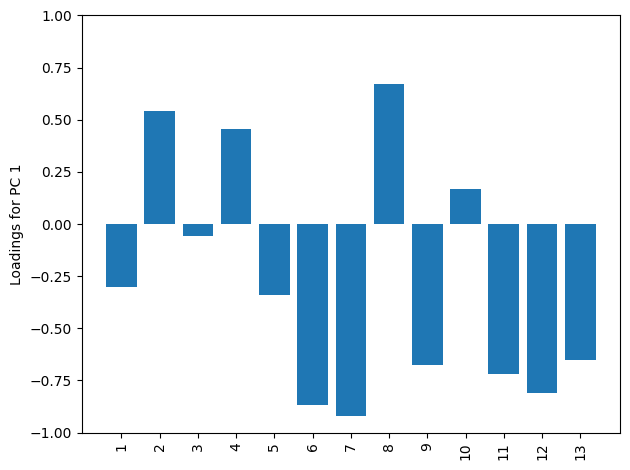

In [16]:
# Plot loadings for first principal component (loadings[:,0])
fig, ax = plt.subplots()                          # Create a figure and axes for plotting

ax.bar(range(13), loadings[:, 0], align='center') # Plot bar chart of loadings for the first principal component (PC 1)
                                                  # 'loadings[:, 0]' means loadings of all features on PC 1

ax.set_ylabel('Loadings for PC 1')                # Label y-axis
ax.set_xticks(range(13))                           # Set x-axis ticks to match the number of features (13)
ax.set_xticklabels(df_wine.columns[1:], rotation=90) # Label x-axis ticks with feature names, rotated 90 degrees for readability

plt.ylim([-1, 1])                                 # Set y-axis limits to between -1 and 1 for clarity
plt.tight_layout()                                # Adjust layout so nothing overlaps
plt.show()                                        # Display the plot

In [17]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_) #  computes the loadings of the original features on each principal component
# pca.components_ represents the eigenvectors (principal components)
# pca.explained_variance_ contains the eigenvalues (variance explained by each component)

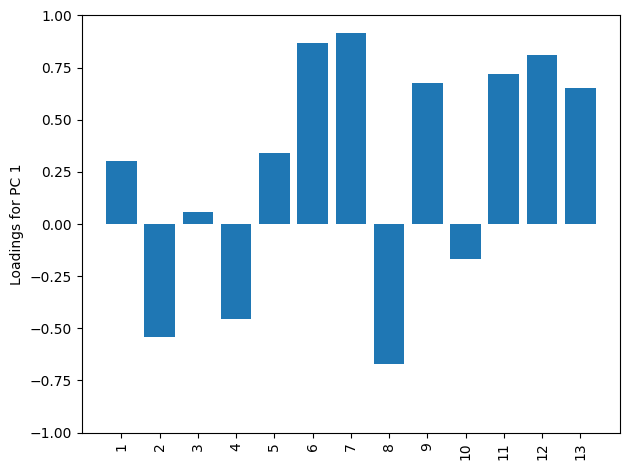

In [18]:
# Compare the loadings from manual calculation and Scikit-Learn
fig, ax = plt.subplots()                          # Create a new figure and axis object for plotting

ax.bar(range(13), sklearn_loadings[:, 0], align='center')  # Plot a bar chart of the loadings for the first principal component (PC 1)
                                                          # sklearn_loadings[:, 0] is the loadings of each feature on PC 1

ax.set_ylabel('Loadings for PC 1')                # Label the y-axis
ax.set_xticks(range(13))                           # Set the x-axis ticks to be from 0 to 12 (for all 13 features)
ax.set_xticklabels(df_wine.columns[1:], rotation=90)  # Label x-axis ticks with feature names (rotated for readability)

plt.ylim([-1, 1])                                 # Set y-axis limits between -1 and 1 to focus on loadings scale
plt.tight_layout()                                # Adjust layout so nothing overlaps or is cut off
plt.show()                                        # Display the plot

## Linear Discriminant Analysis (LDA)

### Computing the Scatter Matrices

In [20]:
# In the PCA section we already standardized the training data, so we can skip step 1
# Proceeding with calculation of mean vectors:

np.set_printoptions(precision=4)  
# Set NumPy to print arrays with 4 decimal places for readability

mean_vecs = []  
# Create an empty list to store mean vectors for each class

for label in range(1, 4):  
    # Loop over the class labels (1, 2, 3 in the wine dataset)
    
    mean_vecs.append(
        np.mean(X_train_std[y_train == label], axis=0)
    )
    # For each class, compute the mean of all standardized training samples
    # axis=0 ensures we get the mean for each feature (column)

    print(f'MV {label}: {mean_vecs[label - 1]}\n')
    # Print the mean vector for that class

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [21]:
# With the mean vectors, we can now compute the within-class scatter matrix (SW)
d = 13  # number of features in the dataset (wine data has 13 features)

S_W = np.zeros((d, d))  
# Initialize the within-class scatter matrix as a 13x13 zero matrix

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  
    # Temporary scatter matrix for the current class

    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  
        # Reshape row (a single sample) and mean vector to column vectors

        class_scatter += (row - mv).dot((row - mv).T)  
        # Add the outer product of the deviation (row - mean) to scatter matrix

    S_W += class_scatter  
    # Add the class scatter to the total within-class scatter

print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [22]:
# We are assumping that the training data is uniformly distributed, but we can see that the assumption is not true
print('Class label distribution:', np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [ ]:
# Want to scale the indevidual scatter matricies S_i before we sume them up as S_W
d = 13  # number of features
S_W = np.zeros((d, d))  # initialize 13x13 zero matrix

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)  
    # Compute the covariance matrix of the features for each class # covariance matrix is a measure of how much the features vary together, and is a normalized version of the scatter matrix
    # (transpose because np.cov expects rows as variables, columns as samples)

    S_W += class_scatter  
    # Add this class's scatter (covariance) to the total within-class scatter

print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


In [24]:
# Can move on and compute the between-class scatter matrix (SB)
mean_overall = np.mean(X_train_std, axis=0)  
# Compute the mean vector across *all* training samples
mean_overall = mean_overall.reshape(d, 1)  
# Reshape to a column vector (d x 1)

d = 13  # number of features
S_B = np.zeros((d, d))  # initialize 13x13 zero matrix

for i, mean_vec in enumerate(mean_vecs):  
    n = X_train_std[y_train == i + 1, :].shape[0]  
    # number of samples in class i

    mean_vec = mean_vec.reshape(d, 1)  
    # reshape class mean into column vector

    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T
    )
    # weighted outer product of (class mean - overall mean)
    # scaled by number of samples in that class

In [26]:
# Remaining steps are similar to PCA, we need to compute the eigenvalues and eigenvectors of the matrix S_W^-1 * S_B
eigen_vals, eigen_vecs = np.linalg.eig(
    np.linalg.inv(S_W).dot(S_B)
)

In [27]:
# Pair each eigenvalue with its corresponding eigenvector
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort eigenpairs from largest to smallest eigenvalue
eigen_pairs = sorted(eigen_pairs,
                     key=lambda k: k[0],
                     reverse=True)

# Print eigenvalues in descending order
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.76152218979394
3.468545711267725e-14
2.842170943040401e-14
2.7442063449887868e-14
2.7442063449887868e-14
9.575021326720663e-15
9.575021326720663e-15
9.461437121374579e-15
8.932653014240921e-15
8.449943185761236e-15
2.9484922158293148e-15
1.2518544322246436e-15


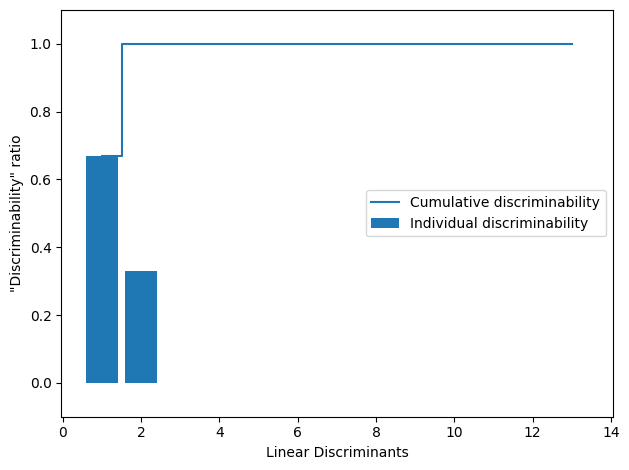

In [ ]:
tot = sum(eigen_vals.real)
# Total "discriminability" across all eigenvalues (only take the real part)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
# Normalize each eigenvalue -> proportion of discriminability for each LD axis

cum_discr = np.cumsum(discr)
# Cumulative sum, to see how much discriminability is captured by top axes

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
# Bar plot of each individual linear discriminant’s contribution

plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
# Step plot showing cumulative contribution

plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show() # First two linear discriminants cover 100 percent of the useful information in the data

In [ ]:
# Stack the top 2 eigenvectors (linear discriminants) to form the projection matrix W
w = np.hstack((
    eigen_pairs[0][1][:, np.newaxis].real,
    eigen_pairs[1][1][:, np.newaxis].real
))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


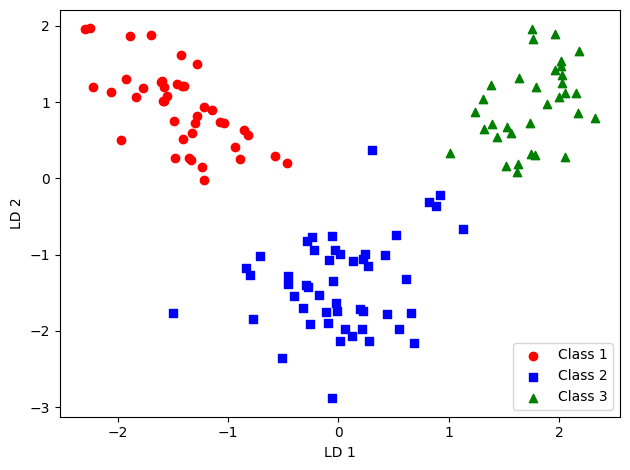

In [ ]:
# Transform the training data onto the LDA subspace
# Project the standardized training data onto the 2D LDA space using the projection matrix w
X_train_lda = X_train_std.dot(w)

# Define colors and markers for each class (3 classes in this dataset)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

# Plot the data points for each class separately
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_lda[y_train == l, 0],         # LD1 values for class l
        X_train_lda[y_train == l, 1] * (-1),  # LD2 values inverted for better visualization
        c=c,                                 # Color for class l
        label=f'Class {l}',                   # Legend label
        marker=m                             # Marker style for class l
    )

plt.xlabel('LD 1')          # Label x-axis as Linear Discriminant 1
plt.ylabel('LD 2')          # Label y-axis as Linear Discriminant 2
plt.legend(loc='lower right')  # Position legend in lower right
plt.tight_layout()          # Adjust layout for better spacing
plt.show()                  # Display the plot
# Wine class is now perfectly separable after projecting the data onto the first two linear discriminants

In [33]:
# LDA in Scikit-Learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Initialize LDA with 2 components to reduce data to 2 linear discriminants
lda = LDA(n_components=2)

# Fit LDA model on standardized training data and transform it to 2D LDA space
X_train_lda = lda.fit_transform(X_train_std, y_train)

C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


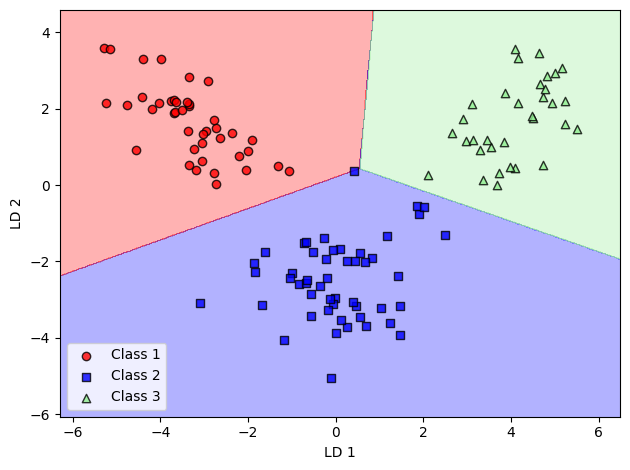

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Initialize logistic regression classifier with one-vs-rest setting
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

# Train logistic regression on the LDA-transformed training data
lr = lr.fit(X_train_lda, y_train)

# Plot decision regions of the trained logistic regression on LDA features
plot_decision_regions(X_train_lda, y_train, classifier=lr)

plt.xlabel('LD 1')           # Label x-axis as Linear Discriminant 1
plt.ylabel('LD 2')           # Label y-axis as Linear Discriminant 2
plt.legend(loc='lower left') # Position legend in lower left
plt.tight_layout()           # Adjust layout for better spacing
plt.show()                   # Show the plot
# One example is misclassified

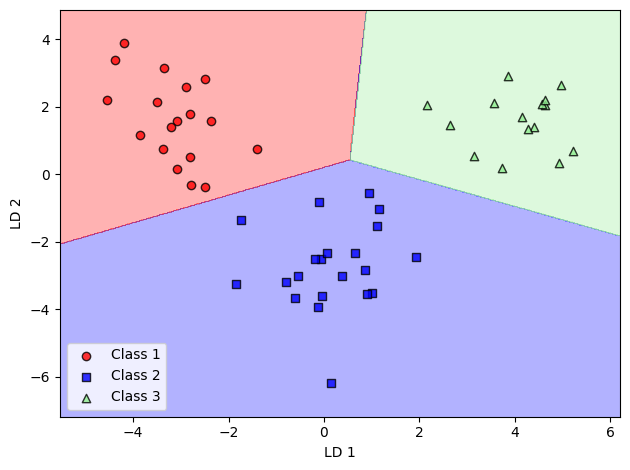

In [ ]:
# Reducing the regularization strength, we can probably shift the decision boundaries so that all examples are classified correctly
# But we should more importantly look at results on the test set
# Transform the standardized test data using the trained LDA model
X_test_lda = lda.transform(X_test_std)

# Plot decision regions for the logistic regression classifier on test LDA data
plot_decision_regions(X_test_lda, y_test, classifier=lr)

plt.xlabel('LD 1')           # Label x-axis as Linear Discriminant 1
plt.ylabel('LD 2')           # Label y-axis as Linear Discriminant 2
plt.legend(loc='lower left') # Position legend in lower left
plt.tight_layout()           # Adjust layout for better spacing
plt.show()                   # Show the plot
# Perfect accuracy on the test set

## Nonlinear DR Techniques

### Visualizing data via t-distributed Stochastic Neighbor Embedding (t-SNE)

In [37]:
# Will use digits dataset from Scikit-Learn for t-SNE visualization
from sklearn.datasets import load_digits

# Load the digits dataset, which contains images of handwritten digits (0-9)
digits = load_digits()

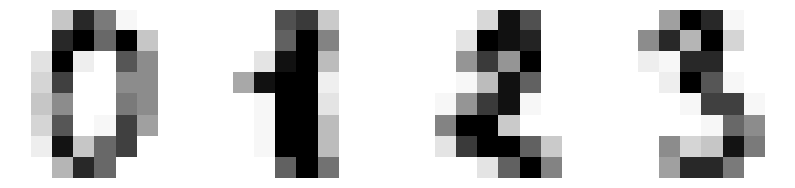

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(10, 3))

# Loop through the first 4 digit images and display them
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
    ax[i].axis('off')  # Hide the axis for a cleaner look

plt.show()

In [39]:
# Check the shape of the digits data matrix (each row is a flattened image)
digits.data.shape

(1797, 64)

In [40]:
# Extract target labels (digits 0-9)
y_digits = digits.target

# Extract feature data (flattened 8x8 images)
X_digits = digits.data

In [41]:
from sklearn.manifold import TSNE

# Initialize t-SNE for 2D embedding, starting with PCA initialization for better convergence
tsne = TSNE(n_components=2, init='pca', random_state=123)

# Fit t-SNE on digit data and transform it to 2D space
X_digits_tsne = tsne.fit_transform(X_digits)

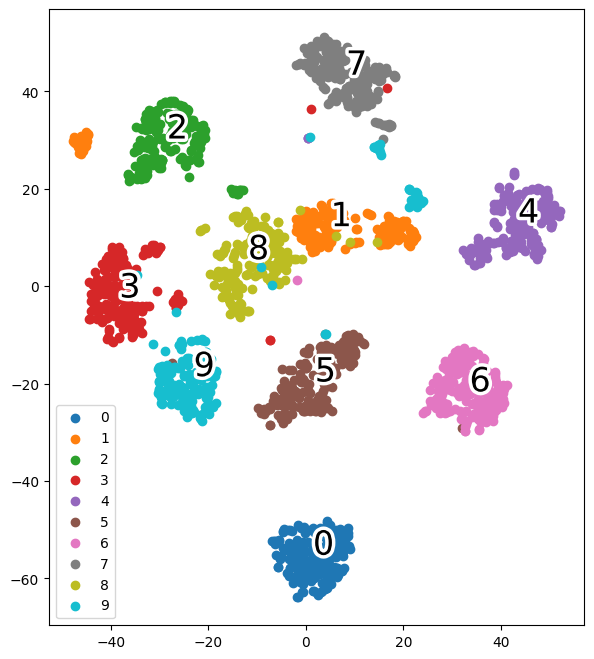

In [42]:
# Visualize
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np

def plot_projection(x, colors):
    # Create a square figure and axis with equal aspect ratio
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    # Plot each digit class separately with scatter plot
    for i in range(10):
        plt.scatter(x[colors == i, 0], x[colors == i, 1], label=str(i))

    # Place large text labels (digits) near the median position of each class
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)

        # Add a white outline to text for better visibility
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()
        ])

    plt.legend()
    plt.show()

# Call the function with t-SNE 2D data and digit labels
plot_projection(X_digits_tsne, y_digits)